# 时间与孕周数据处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

warnings.filterwarnings("ignore")

# 设置中文字体
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

In [2]:
# 加载数据
男胎检测数据 = pd.read_csv('男胎检测数据.csv')
print(f"原始数据形状: {男胎检测数据.shape}")
print(f"原始数据列数: {len(男胎检测数据.columns)}")
print("数据基本信息:")
男胎检测数据.head()

原始数据形状: (1082, 31)
原始数据列数: 31
数据基本信息:


,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Y染色体浓度,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,A001,31,160.0,72.0,2023/2/1,自然受孕,20230429,1,11w+6,...,0.025936,0.038061,0.377069,0.389803,0.399399,0.027484,NaN,1,0,是
1,2,A001,31,160.0,73.0,2023/2/1,自然受孕,20230531,2,15w+6,...,0.034887,0.059572,0.371542,0.384771,0.391706,0.019617,NaN,1,0,是
2,3,A001,31,160.0,73.0,2023/2/1,自然受孕,20230625,3,20w+1,...,0.066171,0.075995,0.377449,0.390582,0.399480,0.022312,NaN,1,0,是
3,4,A001,31,160.0,74.0,2023/2/1,自然受孕,20230716,4,22w+6,...,0.061192,0.052305,0.375613,0.389251,0.397212,0.023280,NaN,1,0,是
4,5,A002,32,149.0,74.0,2023/11/9,自然受孕,20240219,1,13w+6,...,0.059230,0.059708,0.380260,0.393618,0.404868,0.024212,NaN,2,1,否


# 数据质量检查与统计

In [3]:
# 数据质量检查
print("=== 数据质量报告 ===")
print(f"总记录数: {len(男胎检测数据)}")
print(f"唯一孕妇数: {男胎检测数据['孕妇代码'].nunique()}")
print()

# 缺失值统计
print("缺失值统计:")
missing_stats = 男胎检测数据.isnull().sum()
missing_stats = missing_stats[missing_stats > 0].sort_values(ascending=False)
if len(missing_stats) > 0:
    print(missing_stats)
else:
    print("无缺失值")
print()

# 关键字段统计
key_fields = ['末次月经', '检测日期', '检测孕周', '孕妇BMI', 'Y染色体浓度']
print("关键字段统计:")
for field in key_fields:
    if field in 男胎检测数据.columns:
        print(f"{field}: {男胎检测数据[field].count()}/{len(男胎检测数据)} 非空")

=== 数据质量报告 ===
总记录数: 1082
唯一孕妇数: 267

缺失值统计:
染色体的非整倍体    956
末次月经         12
dtype: int64

关键字段统计:
末次月经: 1070/1082 非空
检测日期: 1082/1082 非空
检测孕周: 1082/1082 非空
孕妇BMI: 1082/1082 非空
Y染色体浓度: 1082/1082 非空


In [4]:
print("末次月经统计信息:")
print(男胎检测数据.末次月经.describe())
print()
print("检测日期统计信息:")
print(男胎检测数据.检测日期.describe())

末次月经统计信息:
count           1070
unique           190
top       2022-12-28
freq              32
Name: 末次月经, dtype: object

检测日期统计信息:
count    1.082000e+03
mean     2.023192e+07
std      3.287620e+03
min      2.023010e+07
25%      2.023043e+07
50%      2.023061e+07
75%      2.023102e+07
max      2.024053e+07
Name: 检测日期, dtype: float64


In [5]:
# 将['末次月经', '检测日期']转为datetime类型
print("转换日期格式...")
男胎检测数据['末次月经'] = pd.to_datetime(男胎检测数据['末次月经'], errors='coerce')
男胎检测数据['检测日期'] = pd.to_datetime(男胎检测数据['检测日期'].astype(str), format='%Y%m%d', errors='coerce')

print("日期转换结果:")
print(男胎检测数据[['末次月经', '检测日期']].head())
print()

# 检查日期转换后的缺失值
date_missing = 男胎检测数据[['末次月经', '检测日期']].isnull().sum()
print("日期转换后缺失值:")
print(date_missing)

转换日期格式...
日期转换结果:
        末次月经       检测日期
0 2023-02-01 2023-04-29
1 2023-02-01 2023-05-31
2 2023-02-01 2023-06-25
3 2023-02-01 2023-07-16
4 2023-11-09 2024-02-19

日期转换后缺失值:
末次月经    412
检测日期      0
dtype: int64


In [6]:
# 孕周数据分析
print("原始孕周数据样例:")
孕周数据 = 男胎检测数据.检测孕周
print(孕周数据.head(10))
print()
print("孕周数据类型统计:")
print(孕周数据.value_counts().head(10))

原始孕周数据样例:
0    11w+6
1    15w+6
2    20w+1
3    22w+6
4    13w+6
5    16w+5
6    19w+5
7    23w+4
8    23w+4
9      13w
Name: 检测孕周, dtype: object

孕周数据类型统计:
检测孕周
12w+2    34
13w+4    29
16w+1    28
16w+2    28
13w+1    25
16w+4    23
20w      23
13w+5    22
13w+2    22
12w+4    22
Name: count, dtype: int64


In [7]:
import re

def convert_gestational_age(age_str):
    """转换孕周格式为数值"""
    if pd.isna(age_str):
        return np.nan
    
    # 处理字符串格式
    age_str = str(age_str).strip()
    
    # 匹配 "数字w+数字" 或 "数字w" 格式
    match = re.match(r'(\d+)w\+?(\d+)?', age_str)
    if match:
        weeks, days = match.groups()
        weeks = int(weeks)
        days = int(days) if days else 0
        return weeks + (days / 7)
    
    # 尝试直接转换为数字
    try:
        return float(age_str)
    except:
        return np.nan

print("转换孕周数据...")
孕周数据_数值 = 孕周数据.apply(convert_gestational_age)
孕周数据_数值 = 孕周数据_数值.round(2)

print(f"转换前样例: {孕周数据.head().tolist()}")
print(f"转换后样例: {孕周数据_数值.head().tolist()}")
print()

# 更新数据
男胎检测数据['检测孕周'] = 孕周数据_数值

# 孕周统计
print("孕周数值统计:")
print(男胎检测数据['检测孕周'].describe())

转换孕周数据...
转换前样例: ['11w+6', '15w+6', '20w+1', '22w+6', '13w+6']
转换后样例: [11.86, 15.86, 20.14, 22.86, 13.86]

孕周数值统计:
count    1082.000000
mean       16.845638
std         4.076388
min        11.000000
25%        13.290000
50%        16.000000
75%        20.000000
max        29.000000
Name: 检测孕周, dtype: float64


# 数据过滤与质量控制

In [8]:
# 数据过滤 - 参考final.py的过滤策略
print("=== 数据过滤与质量控制 ===")
原始长度 = len(男胎检测数据)
print(f"原始数据: {原始长度}条记录")

# 1. 过滤检测孕周：保留 [10, 24) 区间
print("\n1. 孕周过滤...")
孕周过滤前 = len(男胎检测数据)
男胎检测数据 = 男胎检测数据[(男胎检测数据['检测孕周'] >= 10) & (男胎检测数据['检测孕周'] < 24)]
print(f"孕周过滤 [10w, 24w): {孕周过滤前} -> {len(男胎检测数据)}条记录")

# 2. 过滤BMI极端异常值
print("\n2. BMI异常值过滤...")
BMI过滤前 = len(男胎检测数据)

# 使用IQR方法识别异常值
Q1 = 男胎检测数据['孕妇BMI'].quantile(0.25)
Q3 = 男胎检测数据['孕妇BMI'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值范围（1.2倍IQR规则，但设置合理的BMI范围）
lower_bound = max(Q1 - 1.2 * IQR, 15.0)  # BMI不低于15
upper_bound = min(Q3 + 1.2 * IQR, 50.0)  # BMI不高于50

男胎检测数据 = 男胎检测数据[(男胎检测数据['孕妇BMI'] >= lower_bound) & (男胎检测数据['孕妇BMI'] <= upper_bound)]
print(f"BMI异常值过滤 [{lower_bound:.1f}, {upper_bound:.1f}]: {BMI过滤前} -> {len(男胎检测数据)}条记录")

# 3. 过滤其他必要的缺失值
print("\n3. 缺失值过滤...")
缺失值过滤前 = len(男胎检测数据)
必要字段 = ['孕妇代码', '孕妇BMI', '检测孕周', 'Y染色体浓度']
男胎检测数据 = 男胎检测数据.dropna(subset=必要字段)
print(f"关键字段缺失值过滤: {缺失值过滤前} -> {len(男胎检测数据)}条记录")

print(f"\n总过滤结果: {原始长度} -> {len(男胎检测数据)}条记录 (过滤掉{原始长度 - len(男胎检测数据)}条, {(原始长度 - len(男胎检测数据))/原始长度*100:.1f}%)")

# 重置索引
男胎检测数据 = 男胎检测数据.reset_index(drop=True)

=== 数据过滤与质量控制 ===
原始数据: 1082条记录

1. 孕周过滤...
孕周过滤 [10w, 24w): 1082 -> 1005条记录

2. BMI异常值过滤...
BMI异常值过滤 [25.7, 38.3]: 1005 -> 960条记录

3. 缺失值过滤...
关键字段缺失值过滤: 960 -> 960条记录

总过滤结果: 1082 -> 960条记录 (过滤掉122条, 11.3%)


# 特征工程与派生变量

In [9]:
# 特征工程 - 参考final.py的多因素特征
print("=== 特征工程 ===")

# 1. BMI分类
def categorize_bmi(bmi):
    """BMI分类"""
    if bmi < 18.5:
        return '偏瘦'
    elif bmi < 24:
        return '正常'
    elif bmi < 28:
        return '超重'
    else:
        return '肥胖'

男胎检测数据['BMI分类'] = 男胎检测数据['孕妇BMI'].apply(categorize_bmi)

# 2. 年龄分组
def categorize_age(age):
    """年龄分组"""
    if age < 25:
        return '年轻'
    elif age < 35:
        return '适龄'
    else:
        return '高龄'

男胎检测数据['年龄分组'] = 男胎检测数据['年龄'].apply(categorize_age)

# 3. 派生特征
if '身高' in 男胎检测数据.columns and '体重' in 男胎检测数据.columns:
    # 身高体重比
    男胎检测数据['身高体重比'] = 男胎检测数据['身高'] / 男胎检测数据['体重']
    
    # 身高和体重的z-score标准化
    男胎检测数据['身高_zscore'] = (男胎检测数据['身高'] - 男胎检测数据['身高'].mean()) / 男胎检测数据['身高'].std()
    男胎检测数据['体重_zscore'] = (男胎检测数据['体重'] - 男胎检测数据['体重'].mean()) / 男胎检测数据['体重'].std()

# 4. BMI与其他因素的交互特征
男胎检测数据['BMI_年龄'] = 男胎检测数据['孕妇BMI'] * 男胎检测数据['年龄']
男胎检测数据['BMI_孕周'] = 男胎检测数据['孕妇BMI'] * 男胎检测数据['检测孕周']

# 5. 达标状态
阈值 = 0.04
男胎检测数据['Y染色体达标'] = (男胎检测数据['Y染色体浓度'] >= 阈值).astype(int)

print("特征工程完成")
print(f"新增特征: BMI分类, 年龄分组, BMI_年龄, BMI_孕周, Y染色体达标")
if '身高' in 男胎检测数据.columns:
    print("新增特征: 身高体重比, 身高_zscore, 体重_zscore")

=== 特征工程 ===
特征工程完成
新增特征: BMI分类, 年龄分组, BMI_年龄, BMI_孕周, Y染色体达标
新增特征: 身高体重比, 身高_zscore, 体重_zscore


# 数据统计与分析

In [10]:
# 数据统计分析
print("=== 处理后数据统计 ===")
print(f"最终数据形状: {男胎检测数据.shape}")
print(f"唯一孕妇数: {男胎检测数据['孕妇代码'].nunique()}")
print()

# 关键指标统计
关键指标 = ['年龄', '身高', '体重', '孕妇BMI', '检测孕周', 'Y染色体浓度']
print("关键指标统计:")
for 指标 in 关键指标:
    if 指标 in 男胎检测数据.columns:
        print(f"{指标}: 均值={男胎检测数据[指标].mean():.2f}, 标准差={男胎检测数据[指标].std():.2f}")

print()

# 分类变量统计
print("BMI分类分布:")
print(男胎检测数据['BMI分类'].value_counts())
print()

print("年龄分组分布:")
print(男胎检测数据['年龄分组'].value_counts())
print()

print("Y染色体达标率:")
达标率 = 男胎检测数据['Y染色体达标'].mean()
print(f"总体达标率: {达标率:.3f} ({达标率*100:.1f}%)")

# 按分组统计达标率
print("\n按BMI分类的达标率:")
print(男胎检测数据.groupby('BMI分类')['Y染色体达标'].agg(['count', 'mean']).round(3))

print("\n按年龄分组的达标率:")
print(男胎检测数据.groupby('年龄分组')['Y染色体达标'].agg(['count', 'mean']).round(3))

=== 处理后数据统计 ===
最终数据形状: (960, 39)
唯一孕妇数: 255

关键指标统计:
年龄: 均值=28.96, 标准差=3.67
身高: 均值=160.95, 标准差=5.14
体重: 均值=82.86, 标准差=8.24
孕妇BMI: 均值=31.94, 标准差=2.30
检测孕周: 均值=16.18, 标准差=3.53
Y染色体浓度: 均值=0.08, 标准差=0.03

BMI分类分布:
BMI分类
肥胖    948
超重     12
Name: count, dtype: int64

年龄分组分布:
年龄分组
适龄    821
年轻     79
高龄     60
Name: count, dtype: int64

Y染色体达标率:
总体达标率: 0.871 (87.1%)

按BMI分类的达标率:
       count   mean
BMI分类              
肥胖       948  0.870
超重        12  0.917

按年龄分组的达标率:
      count   mean
年龄分组              
年轻       79  0.886
适龄      821  0.878
高龄       60  0.750


# 数据可视化

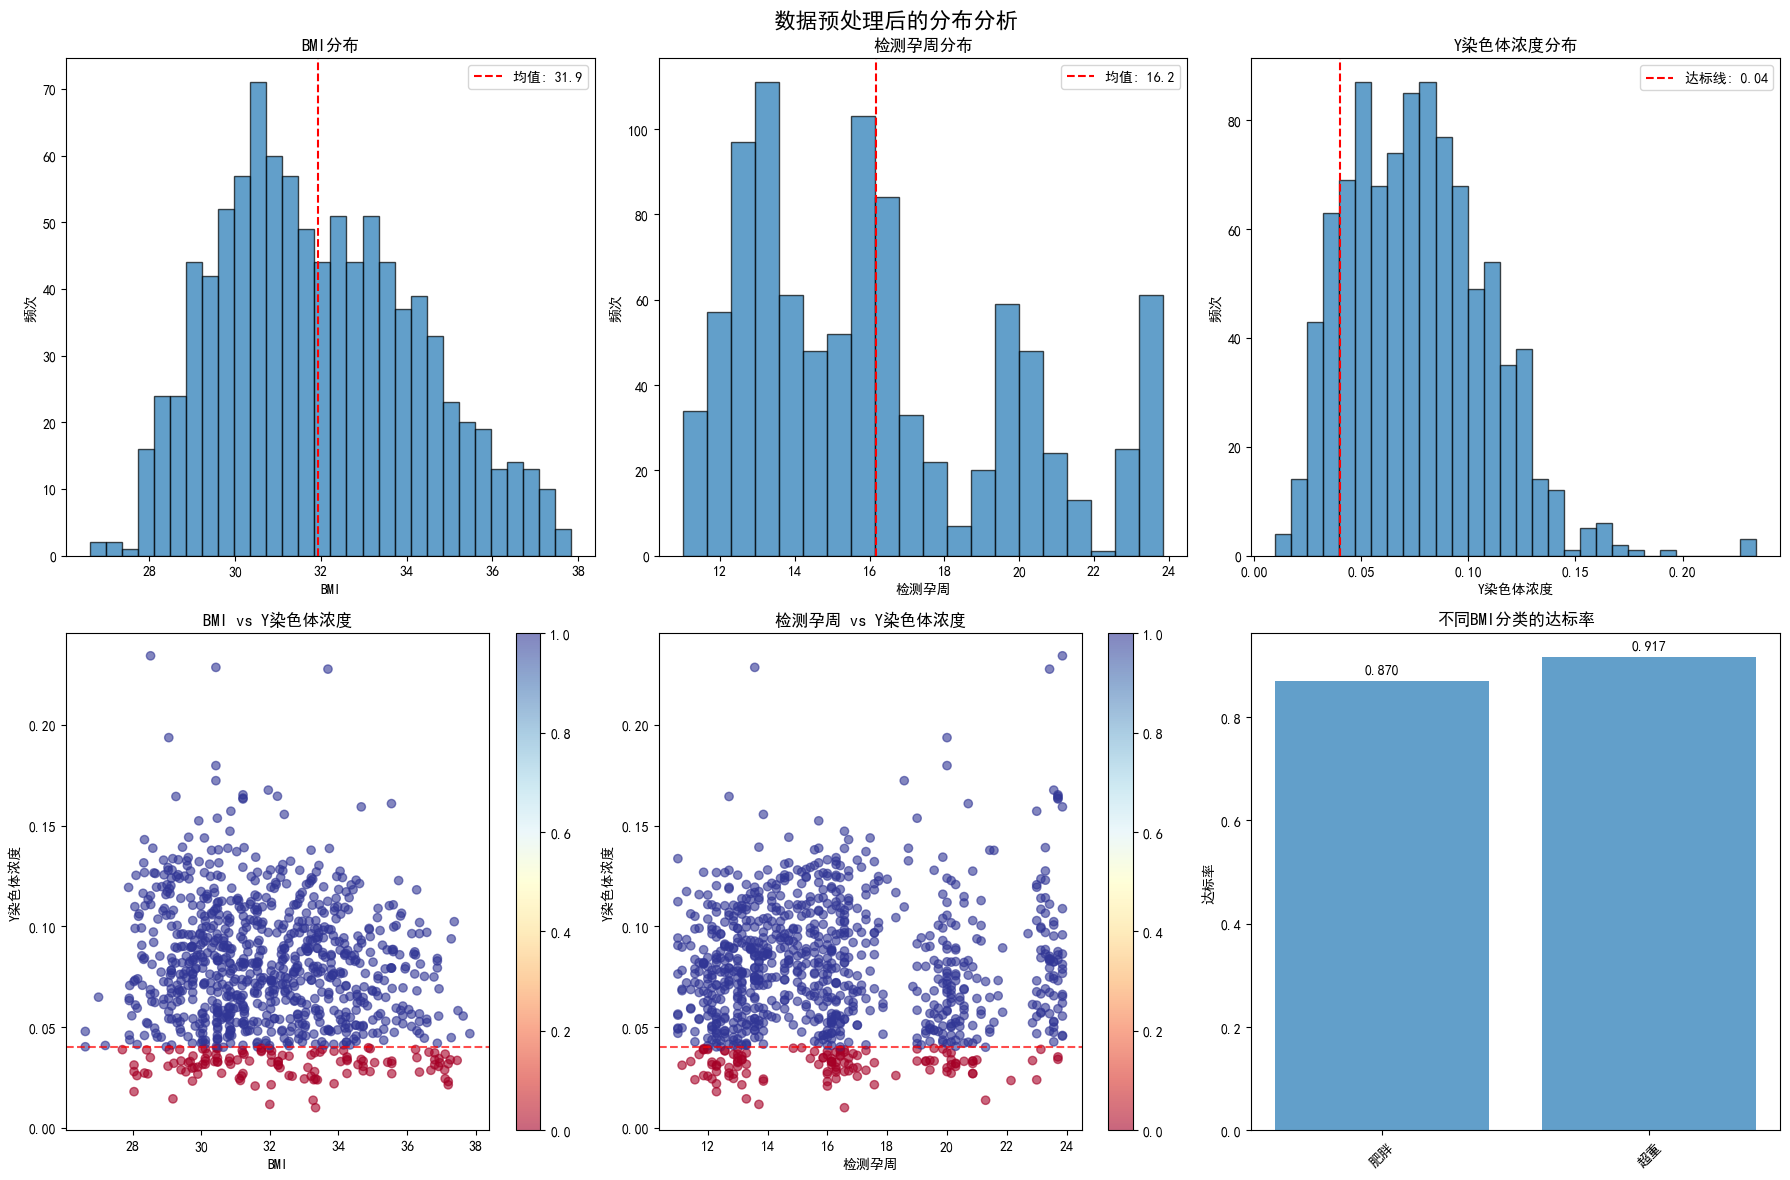

In [11]:
# 数据可视化
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('数据预处理后的分布分析', fontsize=16)

# 1. BMI分布
axes[0, 0].hist(男胎检测数据['孕妇BMI'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('BMI')
axes[0, 0].set_ylabel('频次')
axes[0, 0].set_title('BMI分布')
axes[0, 0].axvline(男胎检测数据['孕妇BMI'].mean(), color='red', linestyle='--', label=f'均值: {男胎检测数据["孕妇BMI"].mean():.1f}')
axes[0, 0].legend()

# 2. 孕周分布
axes[0, 1].hist(男胎检测数据['检测孕周'], bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('检测孕周')
axes[0, 1].set_ylabel('频次')
axes[0, 1].set_title('检测孕周分布')
axes[0, 1].axvline(男胎检测数据['检测孕周'].mean(), color='red', linestyle='--', label=f'均值: {男胎检测数据["检测孕周"].mean():.1f}')
axes[0, 1].legend()

# 3. Y染色体浓度分布
axes[0, 2].hist(男胎检测数据['Y染色体浓度'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Y染色体浓度')
axes[0, 2].set_ylabel('频次')
axes[0, 2].set_title('Y染色体浓度分布')
axes[0, 2].axvline(0.04, color='red', linestyle='--', label='达标线: 0.04')
axes[0, 2].legend()

# 4. BMI vs Y染色体浓度散点图
scatter = axes[1, 0].scatter(男胎检测数据['孕妇BMI'], 男胎检测数据['Y染色体浓度'], 
                           c=男胎检测数据['Y染色体达标'], cmap='RdYlBu', alpha=0.6)
axes[1, 0].set_xlabel('BMI')
axes[1, 0].set_ylabel('Y染色体浓度')
axes[1, 0].set_title('BMI vs Y染色体浓度')
axes[1, 0].axhline(0.04, color='red', linestyle='--', alpha=0.7)
plt.colorbar(scatter, ax=axes[1, 0])

# 5. 孕周 vs Y染色体浓度散点图
scatter2 = axes[1, 1].scatter(男胎检测数据['检测孕周'], 男胎检测数据['Y染色体浓度'], 
                            c=男胎检测数据['Y染色体达标'], cmap='RdYlBu', alpha=0.6)
axes[1, 1].set_xlabel('检测孕周')
axes[1, 1].set_ylabel('Y染色体浓度')
axes[1, 1].set_title('检测孕周 vs Y染色体浓度')
axes[1, 1].axhline(0.04, color='red', linestyle='--', alpha=0.7)
plt.colorbar(scatter2, ax=axes[1, 1])

# 6. 达标率按BMI分类
bmi_attain = 男胎检测数据.groupby('BMI分类')['Y染色体达标'].mean()
axes[1, 2].bar(bmi_attain.index, bmi_attain.values, alpha=0.7)
axes[1, 2].set_ylabel('达标率')
axes[1, 2].set_title('不同BMI分类的达标率')
axes[1, 2].tick_params(axis='x', rotation=45)

# 在每个柱子上标注数值
for i, v in enumerate(bmi_attain.values):
    axes[1, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 多因素相关性分析

=== 多因素相关性分析 ===


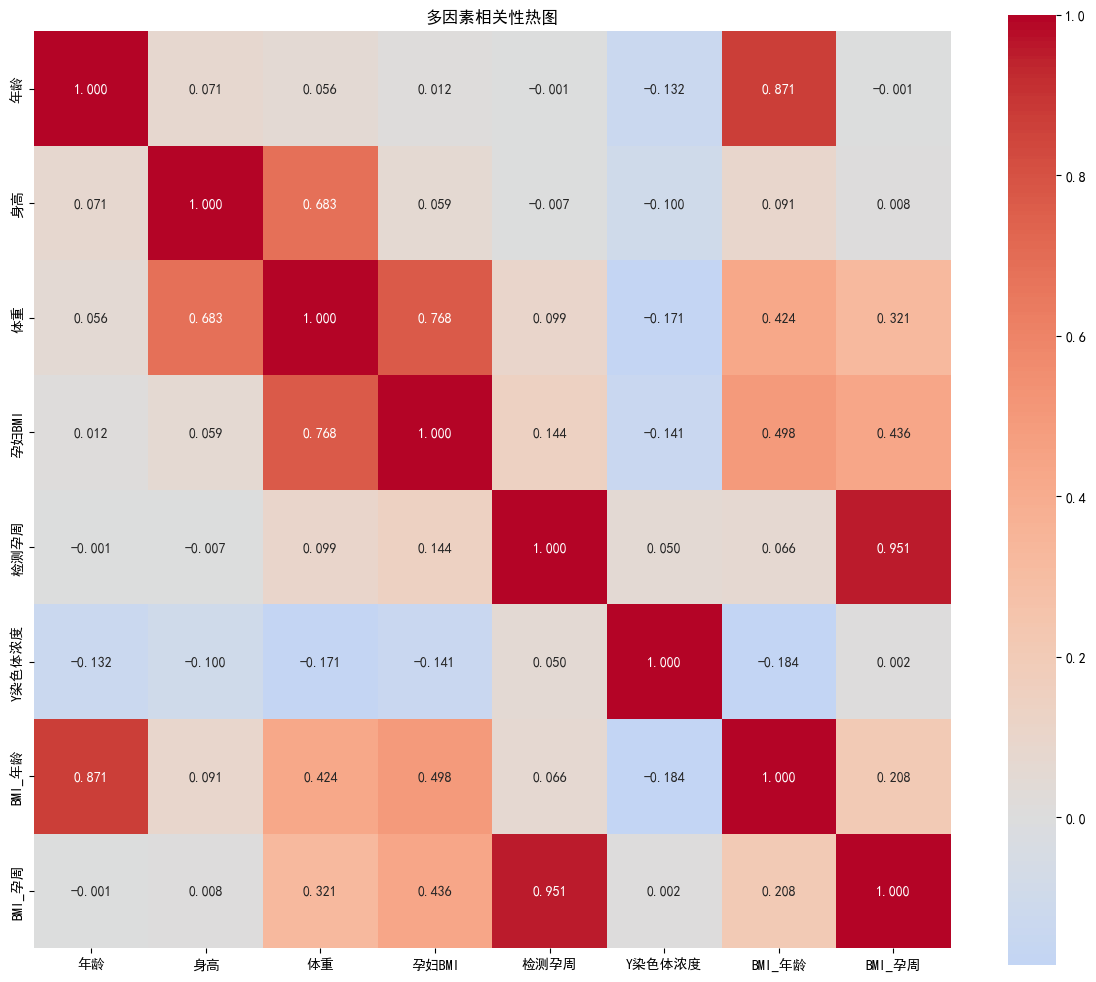

与Y染色体浓度相关性排序:
BMI_年龄: 0.184
体重: 0.171
孕妇BMI: 0.141
年龄: 0.132
身高: 0.100
检测孕周: 0.050
BMI_孕周: 0.002


In [12]:
# 相关性分析
print("=== 多因素相关性分析 ===")

# 选择数值型变量进行相关性分析
数值变量 = ['年龄', '身高', '体重', '孕妇BMI', '检测孕周', 'Y染色体浓度', 'BMI_年龄', 'BMI_孕周']
可用变量 = [var for var in 数值变量 if var in 男胎检测数据.columns]

if len(可用变量) > 2:
    correlation_matrix = 男胎检测数据[可用变量].corr()
    
    # 绘制相关性热图
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f')
    plt.title('多因素相关性热图')
    plt.tight_layout()
    plt.show()
    
    # 输出与Y染色体浓度相关性最高的因素
    if 'Y染色体浓度' in correlation_matrix.columns:
        y_corr = correlation_matrix['Y染色体浓度'].abs().sort_values(ascending=False)
        print("与Y染色体浓度相关性排序:")
        for var, corr in y_corr.items():
            if var != 'Y染色体浓度':
                print(f"{var}: {corr:.3f}")

In [13]:
# 检查处理后的数据
print("检测孕周处理结果:")
print(男胎检测数据['检测孕周'].describe())
print()
print("孕周分布:")
print(男胎检测数据['检测孕周'].value_counts().head(10))

检测孕周处理结果:
count    960.000000
mean      16.181031
std        3.529852
min       11.000000
25%       13.252500
50%       15.710000
75%       19.140000
max       23.860000
Name: 检测孕周, dtype: float64

孕周分布:
检测孕周
12.29    30
13.00    28
13.57    28
16.14    27
16.29    26
16.00    25
13.14    24
16.57    22
13.71    22
20.00    22
Name: count, dtype: int64


# 身体指标计算与验证

In [14]:
# 身体指标验证
print("=== 身体指标验证 ===")
print(f"BMI缺失值数量: {男胎检测数据['孕妇BMI'].isna().sum()}")
print(f"BMI统计信息:")
print(男胎检测数据['孕妇BMI'].describe())

# 验证BMI计算（如果有身高体重数据）
if '身高' in 男胎检测数据.columns and '体重' in 男胎检测数据.columns:
    # 从身高体重计算BMI进行验证
    计算BMI = 男胎检测数据['体重'] / (男胎检测数据['身高']/100)**2
    BMI差异 = abs(男胎检测数据['孕妇BMI'] - 计算BMI)
    
    print(f"\nBMI验证:")
    print(f"BMI计算差异均值: {BMI差异.mean():.3f}")
    print(f"BMI计算差异标准差: {BMI差异.std():.3f}")
    
    # 如果差异较大，可能需要使用计算值
    if BMI差异.mean() > 1.0:
        print("警告: BMI差异较大，建议使用身高体重重新计算")

=== 身体指标验证 ===
BMI缺失值数量: 0
BMI统计信息:
count    960.000000
mean      31.943023
std        2.302591
min       26.619343
25%       30.119402
50%       31.644286
75%       33.564582
max       37.832874
Name: 孕妇BMI, dtype: float64

BMI验证:
BMI计算差异均值: 0.004
BMI计算差异标准差: 0.006


# 最终数据检查

In [15]:
# 最终数据完整性检查
print("=== 最终数据完整性检查 ===")

关键字段 = ['Y染色体浓度', '检测孕周', '孕妇BMI', '孕妇代码']
缺失情况 = 男胎检测数据[关键字段].isna().any(axis=1)

if 缺失情况.sum() > 0:
    print(f"仍有 {缺失情况.sum()} 条记录存在关键字段缺失:")
    print(男胎检测数据.loc[缺失情况, 关键字段])
else:
    print("所有关键字段完整")

# 数据范围检查
print("\n数据范围检查:")
print(f"检测孕周范围: [{男胎检测数据['检测孕周'].min():.1f}, {男胎检测数据['检测孕周'].max():.1f}]")
print(f"BMI范围: [{男胎检测数据['孕妇BMI'].min():.1f}, {男胎检测数据['孕妇BMI'].max():.1f}]")
print(f"Y染色体浓度范围: [{男胎检测数据['Y染色体浓度'].min():.4f}, {男胎检测数据['Y染色体浓度'].max():.4f}]")

# 异常值检查
异常检测 = []
if 男胎检测数据['检测孕周'].min() < 5 or 男胎检测数据['检测孕周'].max() > 30:
    异常检测.append("孕周存在异常值")
if 男胎检测数据['孕妇BMI'].min() < 10 or 男胎检测数据['孕妇BMI'].max() > 60:
    异常检测.append("BMI存在异常值")
if 男胎检测数据['Y染色体浓度'].min() < 0:
    异常检测.append("Y染色体浓度存在负值")

if 异常检测:
    print("\n异常值警告:")
    for 警告 in 异常检测:
        print(f"- {警告}")
else:
    print("\n数据范围正常")

=== 最终数据完整性检查 ===
所有关键字段完整

数据范围检查:
检测孕周范围: [11.0, 23.9]
BMI范围: [26.6, 37.8]
Y染色体浓度范围: [0.0100, 0.2342]

数据范围正常


# 数据导出与总结

In [16]:
# 数据导出
print("=== 数据导出 ===")

# 保存预处理后的完整数据
输出文件名 = '男胎检测数据_预处理后.csv'
男胎检测数据.to_csv(输出文件名, index=False, encoding='utf-8-sig')
print(f"完整预处理数据已保存至: {输出文件名}")

# 保存核心分析数据（只包含建模需要的字段）
核心字段 = ['序号', '孕妇代码', '年龄', '身高', '体重', '孕妇BMI', '检测孕周', 
         'Y染色体浓度', 'Y染色体达标', 'BMI分类', '年龄分组', 'BMI_年龄', 'BMI_孕周']
可用核心字段 = [field for field in 核心字段 if field in 男胎检测数据.columns]

核心数据 = 男胎检测数据[可用核心字段].copy()
核心文件名 = '男胎检测数据_核心特征.csv'
核心数据.to_csv(核心文件名, index=False, encoding='utf-8-sig')
print(f"核心特征数据已保存至: {核心文件名}")

# 生成数据处理报告
处理报告 = {
    '原始记录数': 原始长度,
    '最终记录数': len(男胎检测数据),
    '过滤比例': f"{(原始长度 - len(男胎检测数据))/原始长度*100:.1f}%",
    '唯一孕妇数': 男胎检测数据['孕妇代码'].nunique(),
    '孕周范围': f"[{男胎检测数据['检测孕周'].min():.1f}, {男胎检测数据['检测孕周'].max():.1f}]",
    'BMI范围': f"[{男胎检测数据['孕妇BMI'].min():.1f}, {男胎检测数据['孕妇BMI'].max():.1f}]",
    '总体达标率': f"{男胎检测数据['Y染色体达标'].mean():.3f}",
    '新增特征数': len([col for col in 男胎检测数据.columns if col.endswith(('分类', '分组', '_zscore')) or '_' in col])
}

print("\n=== 数据处理总结报告 ===")
for key, value in 处理报告.items():
    print(f"{key}: {value}")

# 保存处理报告
报告df = pd.DataFrame([处理报告])
报告df.to_csv('数据处理报告.csv', index=False, encoding='utf-8-sig')
print(f"\n处理报告已保存至: 数据处理报告.csv")

=== 数据导出 ===
完整预处理数据已保存至: 男胎检测数据_预处理后.csv
核心特征数据已保存至: 男胎检测数据_核心特征.csv

=== 数据处理总结报告 ===
原始记录数: 1082
最终记录数: 960
过滤比例: 11.3%
唯一孕妇数: 255
孕周范围: [11.0, 23.9]
BMI范围: [26.6, 37.8]
总体达标率: 0.871
新增特征数: 6

处理报告已保存至: 数据处理报告.csv


In [17]:
# 最终检查
print("=== 数据预处理完成 ===")
print(f"最终数据维度: {男胎检测数据.shape}")
print("主要改进:")
print("✓ 添加了数据质量控制和异常值过滤")
print("✓ 实现了多因素特征工程")
print("✓ 加强了数据验证和统计分析")
print("✓ 生成了详细的数据处理报告")
print("✓ 创建了核心特征数据集")
print("\n数据已准备就绪，可用于后续建模分析！")

=== 数据预处理完成 ===
最终数据维度: (960, 39)
主要改进:
✓ 添加了数据质量控制和异常值过滤
✓ 实现了多因素特征工程
✓ 加强了数据验证和统计分析
✓ 生成了详细的数据处理报告
✓ 创建了核心特征数据集

数据已准备就绪，可用于后续建模分析！
